In [ ]:
import tensorflow as tf
import os
import numpy as np
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn import metrics
from tabulate import tabulate
import seaborn as sns
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
##import keras_tuner
##from kerastuner.tuners import RandomSearch
##from kerastuner.engine.hyperparameters import HyperParameters
from prettytable import PrettyTable
from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets import fashion_mnist


In [ ]:
# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [ ]:
# Reshape and normalise the data
x_train = x_train / 255.0
x_test = x_test / 255.0

In [ ]:
print(y_train.shape)
print(y_test.shape)

(60000,)
(10000,)


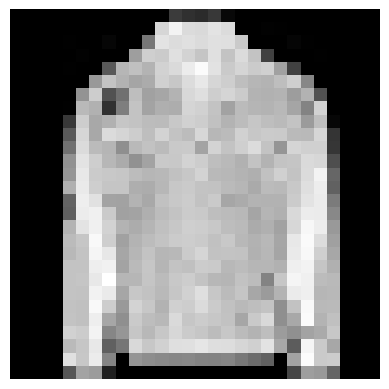

In [ ]:
# Display the reshaped and normalised image
image = x_train[29].reshape(28, 28)  # Assuming the first image is displayed
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
# Split the data into training, validation, and testing sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

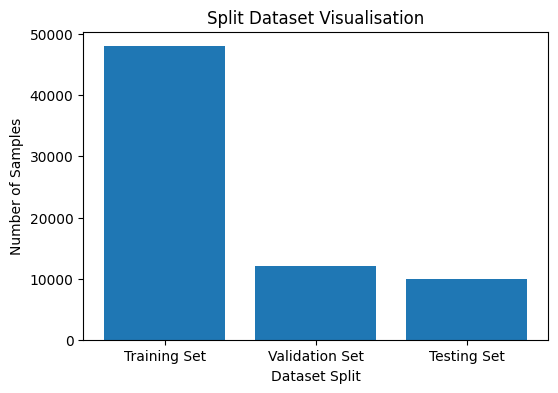

In [ ]:
# Calculate the sizes of each split
train_size = len(x_train)
val_size = len(x_val)
test_size = len(x_test)

#Display the training and Validation Set graph
# Plot the split dataset
plt.figure(figsize=(6, 4))
plt.bar(['Training Set', 'Validation Set', 'Testing Set'], [train_size, val_size, test_size])
plt.xlabel('Dataset Split')
plt.ylabel('Number of Samples')
plt.title('Split Dataset Visualisation')
plt.show()

In [ ]:
class_label = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [ ]:
# Count the occurrences of each digit in the training set
train_digit_counts = np.bincount(y_train)

# Count the occurrences of each digit in the testing set
test_digit_counts = np.bincount(y_test)

# Count the occurrences of each digit in the validation set
val_digit_counts = np.bincount(y_val)

# Calculate the subtotal by adding the counts from the training, validation and testing sets
subtotal_digit_counts = train_digit_counts + val_digit_counts + test_digit_counts

# Calculate the total counts by summing the subtotal counts
total_digit_counts = np.sum(subtotal_digit_counts)

# Generate x-axis labels for each digit
digits = np.arange(10)

# Create a table
table = []
for digit, train_count, val_count, test_count, subtotal_count in zip(
    digits, train_digit_counts, val_digit_counts, test_digit_counts, subtotal_digit_counts
):
    table.append([digit, train_count, val_count, test_count, subtotal_count])

# Append a row for the subtotal
table.append(["Subtotal", np.sum(train_digit_counts), np.sum(val_digit_counts), np.sum(test_digit_counts), np.sum(subtotal_digit_counts)])

# Append a row for the total
table.append(["Total", "", "", total_digit_counts])

# Define the table headers
headers = ["Digit", "Training Set", "Validation Set", "Testing Set", "Subtotal"]

# Print the table
print(tabulate(table, headers, tablefmt="fancy_grid"))

╒══════════╤════════════════╤══════════════════╤═══════════════╤════════════╕
│ Digit    │ Training Set   │ Validation Set   │   Testing Set │   Subtotal │
╞══════════╪════════════════╪══════════════════╪═══════════════╪════════════╡
│ 0        │ 4798           │ 1202             │          1000 │       7000 │
├──────────┼────────────────┼──────────────────┼───────────────┼────────────┤
│ 1        │ 4781           │ 1219             │          1000 │       7000 │
├──────────┼────────────────┼──────────────────┼───────────────┼────────────┤
│ 2        │ 4795           │ 1205             │          1000 │       7000 │
├──────────┼────────────────┼──────────────────┼───────────────┼────────────┤
│ 3        │ 4816           │ 1184             │          1000 │       7000 │
├──────────┼────────────────┼──────────────────┼───────────────┼────────────┤
│ 4        │ 4798           │ 1202             │          1000 │       7000 │
├──────────┼────────────────┼──────────────────┼───────────────┼

In [ ]:
# Create the CNN model function
def build_model(hp):
    model = Sequential()

    ## Tune the number of filters and kernel size for the first convolutional layer
    hp_filters_1 = hp.Int('filters_1', min_value=32, max_value=128, step=32)
    hp_kernel_size_1 = hp.Int('kernel_size_1', min_value=3, max_value=5, step=2)
    model.add(Conv2D(hp_filters_1, (hp_kernel_size_1, hp_kernel_size_1), activation='relu', input_shape=(28, 28, 1)))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Tune the number of filters and kernel size for the second convolutional layer
    hp_filters_2 = hp.Int('filters_2', min_value=64, max_value=256, step=64)
    hp_kernel_size_2 = hp.Int('kernel_size_2', min_value=3, max_value=5, step=2)
    model.add(Conv2D(hp_filters_2, (hp_kernel_size_2, hp_kernel_size_2), activation='relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())

    # Tune the number of units in the dense layer
    hp_units = hp.Int('units', min_value=128, max_value=512, step=128)
    model.add(Dense(hp_units, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    # Tune the learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    optimizer = Adam(learning_rate=hp_learning_rate)

    # Compile the model with the specified learning rate
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy'],
    )

    return model

In [ ]:
# Define the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='tuner_results',
    project_name='mnist_tuning'
)

INFO:tensorflow:Reloading Tuner from tuner_results\mnist_tuning\tuner0.json


In [ ]:
tuner.search(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get the best trials
trials = tuner.oracle.get_best_trials(num_trials=5)

In [ ]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
# Create a fancy table
table = PrettyTable()
table.field_names = ["Trial", "filters_1", "kernel_size_1", "filters_2", "kernel_size_2", "Learning Rate", "Units", "Accuracy", "Validation Accuracy"]

# Add trial details to the table
for i, trial in enumerate(trials):
    filters_1 = trial.hyperparameters.get('filters_1')
    kernel_size_1 = trial.hyperparameters.get('kernel_size_1')
    filters_2 = trial.hyperparameters.get('filters_2')
    kernel_size_2 = trial.hyperparameters.get('kernel_size_2')
    learning_rate = trial.hyperparameters.get('learning_rate')
    units = trial.hyperparameters.get('units')
    accuracy = trial.metrics.get_last_value('accuracy')
    val_accuracy = trial.metrics.get_last_value('val_accuracy')
    table.add_row([i+1, filters_1, kernel_size_1, filters_2, kernel_size_2, learning_rate, units, accuracy, val_accuracy])

# Print the fancy table
print(table)

+-------+-----------+---------------+-----------+---------------+---------------+-------+--------------------+---------------------+
| Trial | filters_1 | kernel_size_1 | filters_2 | kernel_size_2 | Learning Rate | Units |      Accuracy      | Validation Accuracy |
+-------+-----------+---------------+-----------+---------------+---------------+-------+--------------------+---------------------+
|   1   |    128    |       3       |    256    |       5       |     0.001     |  128  | 0.9565555453300476 |  0.9138888915379842 |
|   2   |     64    |       3       |    128    |       5       |     0.0001    |  256  | 0.9206388791402181 |  0.9045000076293945 |
|   3   |    128    |       3       |     64    |       3       |      0.01     |  256  | 0.8811666568120321 |  0.8753888805707296 |
|   4   |     96    |       5       |     64    |       3       |      0.01     |  256  | 0.8821388880411783 |  0.8704166611035665 |
|   5   |    128    |       3       |    128    |       5       |    

In [ ]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 128)       1280      
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 256)         819456    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 4, 256)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense (Dense)               (None, 128)               5

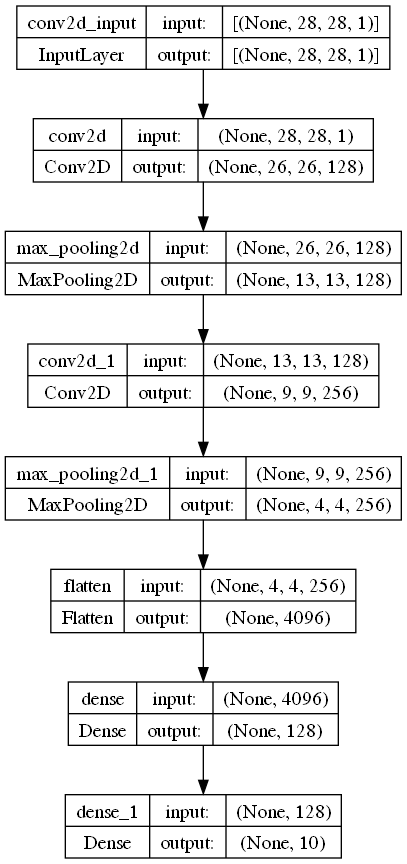

In [ ]:
# Visualize the model architecture
plot_model(best_model, show_shapes=True, show_layer_names=True, expand_nested=True)

In [ ]:
# Train the best model with the optimal hyperparameters and collect training history
history = best_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
1500/1500 [==============================] - 238s 158ms/step - loss: 0.0840 - accuracy: 0.9686 - val_loss: 0.3328 - val_accuracy: 0.9154
Epoch 2/10
1500/1500 [==============================] - 222s 148ms/step - loss: 0.0752 - accuracy: 0.9713 - val_loss: 0.3756 - val_accuracy: 0.9102
Epoch 3/10
1500/1500 [==============================] - 247s 165ms/step - loss: 0.0623 - accuracy: 0.9770 - val_loss: 0.3764 - val_accuracy: 0.9090
Epoch 4/10
1500/1500 [==============================] - 257s 171ms/step - loss: 0.0575 - accuracy: 0.9785 - val_loss: 0.3838 - val_accuracy: 0.9130
Epoch 5/10
1500/1500 [==============================] - 269s 180ms/step - loss: 0.0523 - accuracy: 0.9816 - val_loss: 0.4775 - val_accuracy: 0.9058
Epoch 6/10
1500/1500 [==============================] - 243s 162ms/step - loss: 0.0481 - accuracy: 0.9822 - val_loss: 0.4130 - val_accuracy: 0.9119
Epoch 7/10
1500/1500 [==============================] - 263s 175ms/step - loss: 0.0412 - accuracy: 0.9858 - val_

In [ ]:
best_model.save("CNN_Model_hyperparameter.h5py")

INFO:tensorflow:Assets written to: CNN_Model_hyperparameter.h5py\assets


INFO:tensorflow:Assets written to: CNN_Model_hyperparameter.h5py\assets


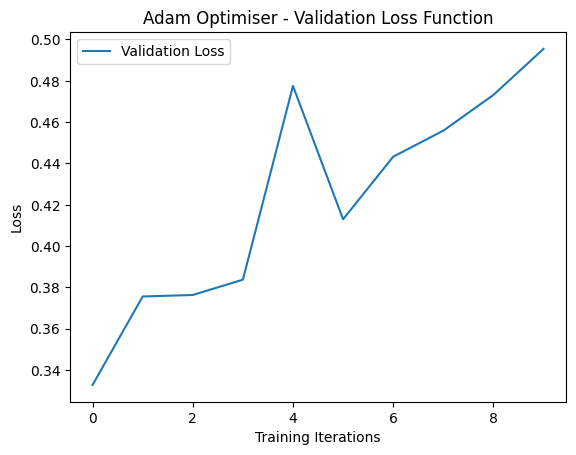

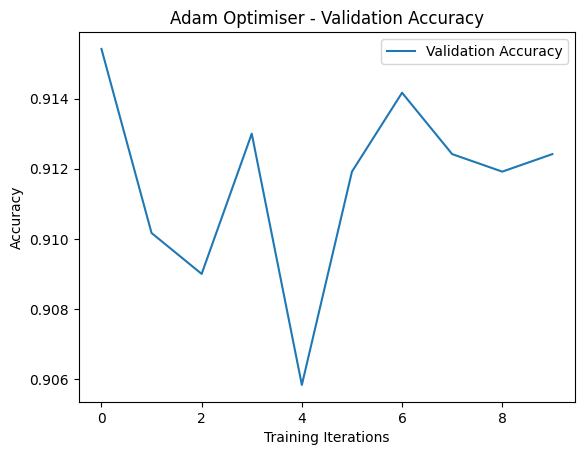

Final Validation Loss: 0.4954323470592499
Final Validation Accuracy: 0.9124166369438171
Final Training Loss: 0.9861249923706055


In [ ]:
# Get the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']
train_accuracy = history.history['accuracy']

# Get the final validation loss and accuracy values
final_train_loss = train_loss[-1]
final_val_loss = val_loss[-1]
final_val_accuracy = val_accuracy[-1]
final_train_accuracy = train_accuracy[-1]

# Create an array of training iteration numbers
iterations = np.arange(len(train_loss))

# Plot the loss function
plt.plot(iterations, val_loss, label='Validation Loss')
plt.xlabel('Training Iterations')
plt.ylabel('Loss')
plt.title('Adam Optimiser - Validation Loss Function')
plt.legend()
plt.show()

# Plot the accuracy
plt.plot(iterations, val_accuracy, label='Validation Accuracy')
plt.xlabel('Training Iterations')
plt.ylabel('Accuracy')
plt.title('Adam Optimiser - Validation Accuracy')
plt.legend()
plt.show()

# Print the final validation loss and accuracy
print("Final Validation Loss:", final_val_loss)
print("Final Validation Accuracy:", final_val_accuracy)
print("Final Training Loss:", final_train_accuracy)


In [ ]:
# Evaluate the best model on the test set
test_loss, test_accuracy =best_model.evaluate(x_test, y_test)

313/313 [==============================] - 8s 24ms/step - loss: 0.5452 - accuracy: 0.9101


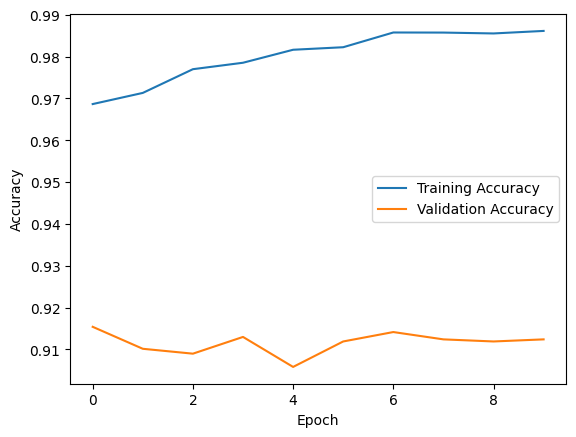

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
# Make predictions on the test set
y_pred = best_model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

313/313 [==============================] - 7s 23ms/step


In [ ]:


# Calculate precision, recall, and F1 score
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Display
print("Loss", test_loss)
print("Accurancy", test_accuracy)
print()
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Loss 0.5451797842979431
Accurancy 0.910099983215332

Accuracy: 0.9101
Precision: 0.9105581600593498
Recall: 0.9101000000000001
F1 Score: 0.9102077741460673


In [ ]:
# Generate classification report
report = classification_report(y_test, y_pred, output_dict=True, zero_division=1)
report_rows = [[label] + list(values.values()) for label, values in report.items() if label not in ['accuracy', 'macro avg', 'weighted avg']]
headers = ['Class', 'Precision', 'Recall', 'F1-Score', 'Support']

# Print the results
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("")

print("Convolutional Neuron Network Report:")
print(tabulate(report_rows, headers=headers, tablefmt='orgtbl'))


Test Loss: 0.5451797842979431
Test Accuracy: 0.910099983215332

Convolutional Neuron Network Report:
|   Class |   Precision |   Recall |   F1-Score |   Support |
|---------+-------------+----------+------------+-----------|
|       0 |    0.85729  |    0.835 |   0.845998 |      1000 |
|       1 |    0.991911 |    0.981 |   0.986425 |      1000 |
|       2 |    0.877358 |    0.837 |   0.856704 |      1000 |
|       3 |    0.90198  |    0.911 |   0.906468 |      1000 |
|       4 |    0.852459 |    0.884 |   0.867943 |      1000 |
|       5 |    0.966667 |    0.986 |   0.976238 |      1000 |
|       6 |    0.741245 |    0.762 |   0.751479 |      1000 |
|       7 |    0.965898 |    0.963 |   0.964447 |      1000 |
|       8 |    0.976931 |    0.974 |   0.975463 |      1000 |
|       9 |    0.973843 |    0.968 |   0.970913 |      1000 |


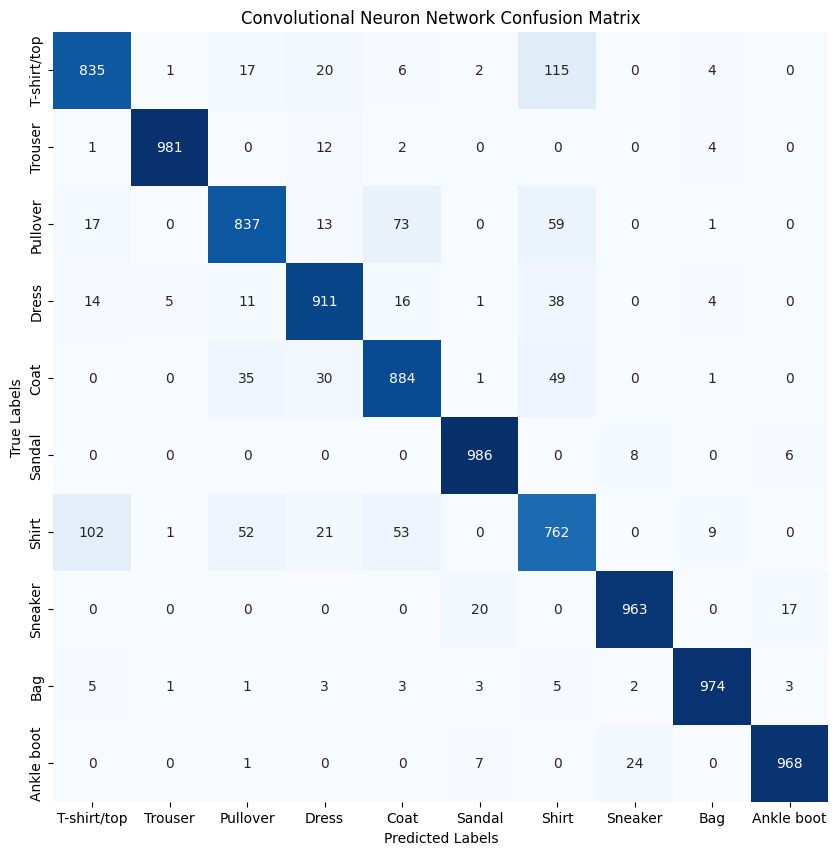

In [ ]:
# Calculate confusion matrix
dnn_cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(dnn_cm, annot=True, cmap="Blues", fmt="d", cbar=False, xticklabels=class_label, yticklabels=class_label)
plt.title("Convolutional Neuron Network Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
# Create a table of accuracies
data = {
    'Dataset': ['Training', 'Validation', 'Test'],
    'Accuracy': [final_train_accuracy, final_val_accuracy, test_accuracy]
}

table = tabulate(data, headers='keys', tablefmt='fancy_grid')

print(table)

╒════════════╤════════════╕
│ Dataset    │   Accuracy │
╞════════════╪════════════╡
│ Training   │   0.986125 │
├────────────┼────────────┤
│ Validation │   0.912417 │
├────────────┼────────────┤
│ Test       │   0.9101   │
╘════════════╧════════════╛


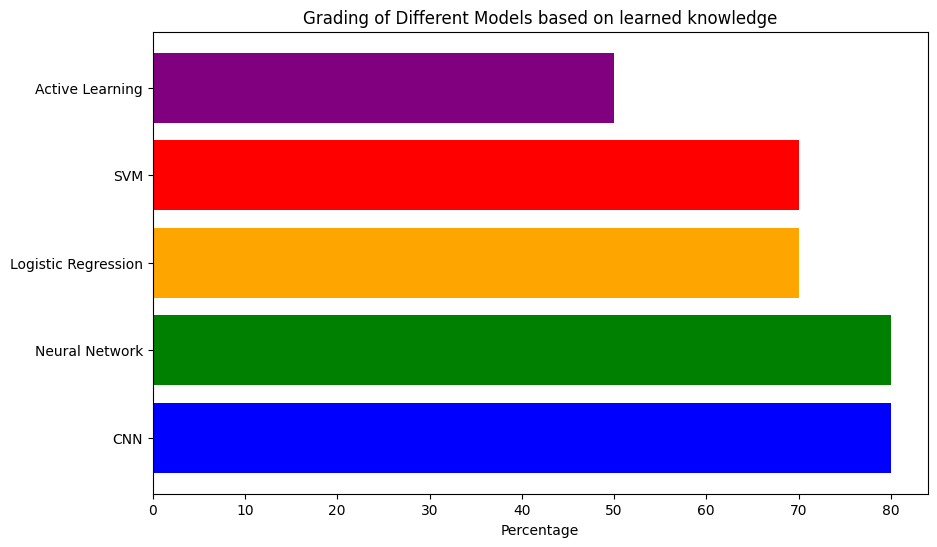

In [ ]:
categories = ['CNN', 'Neural Network', 'Logistic Regression', 'SVM', 'Active Learning']
percentages = [80, 80, 70, 70, 50]  # Adjust these percentages as needed
colors = ['blue', 'green', 'orange', 'red', 'purple']
plt.figure(figsize=(10, 6))
plt.barh(categories, percentages, color=colors)
plt.xlabel('Percentage')
plt.title('Understanding')
plt.show()
